In [1]:
import torch
import random
import copy
import itertools
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import utils
from LIM_deep_neural_classifier import LIMDeepNeuralClassifier
import dataset_addition as da
from trainer import LIMTrainer
import matplotlib.pyplot as plt

C:\Users\attic\anaconda3\envs\bigkid\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
utils.fix_random_seeds()

# Five Digit Addition



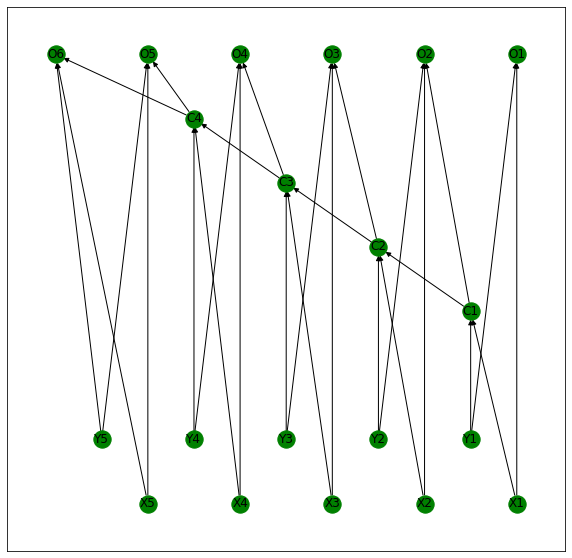

In [3]:
model = da.highlevel_tall_model()
model.print_structure()

In [4]:
input = model.sample_input()

In [5]:
counts = {(c,o):0 for c in ["C4", "C3", "C2", "C1"] for o in  ["O6","O5","O4", "O3", "O2", "O1"] if int(c[1])+1 < int(o[1])}
for _ in range(10000):
    i = model.sample_input()
    paths = model.find_live_paths(i)
    for (c,o) in counts:
        for k in paths:
            for path in paths[k]:
                if path[0] == c and path[-1] == o:
                    counts[(c,o)] += 1
for c in ["C4", "C3", "C2", "C1"]:
    print("\n From " + c)
    for o in  ["O6","O5","O4", "O3", "O2", "O1"]:
        if int(c[1])+1 < int(o[1]):
            print(" To ", o,counts[(c,o)], " ")


 From C4
 To  O6 994  

 From C3
 To  O6 99  
 To  O5 1018  

 From C2
 To  O6 6  
 To  O5 88  
 To  O4 969  

 From C1
 To  O6 1  
 To  O5 5  
 To  O4 91  
 To  O3 962  


In [6]:
model.get_path_maxlen_filter([2])

<function causal_model.CausalModel.get_path_maxlen_filter.<locals>.check_path(total_setting)>

In [7]:
result = da.get_circuit_samplers()

In [8]:
print(result)

{'O1': {}, 'O2': {}, 'O3': {'C1': {'X1': 1.0, 'X2': 4.0, 'X3': 8.0, 'X4': 1.0, 'X5': 8.0, 'Y1': 6.0, 'Y2': 5.0, 'Y3': 9.0, 'Y4': 9.0, 'Y5': 1.0}}, 'O4': {'C2': {'X1': 4.0, 'X2': 3.0, 'X3': 1.0, 'X4': 9.0, 'X5': 2.0, 'Y1': 3.0, 'Y2': 2.0, 'Y3': 8.0, 'Y4': 9.0, 'Y5': 5.0}, 'C1': {'X1': 3.0, 'X2': 7.0, 'X3': 6.0, 'X4': 2.0, 'X5': 2.0, 'Y1': 1.0, 'Y2': 2.0, 'Y3': 3.0, 'Y4': 3.0, 'Y5': 4.0}}, 'O5': {'C3': {'X1': 6.0, 'X2': 1.0, 'X3': 6.0, 'X4': 4.0, 'X5': 8.0, 'Y1': 6.0, 'Y2': 1.0, 'Y3': 9.0, 'Y4': 5.0, 'Y5': 8.0}, 'C2': {'X1': 9.0, 'X2': 8.0, 'X3': 7.0, 'X4': 6.0, 'X5': 4.0, 'Y1': 8.0, 'Y2': 5.0, 'Y3': 2.0, 'Y4': 3.0, 'Y5': 2.0}, 'C1': {'X1': 7.0, 'X2': 0.0, 'X3': 0.0, 'X4': 7.0, 'X5': 8.0, 'Y1': 8.0, 'Y2': 9.0, 'Y3': 9.0, 'Y4': 2.0, 'Y5': 8.0}}, 'O6': {'C4': {'X1': 2.0, 'X2': 8.0, 'X3': 6.0, 'X4': 7.0, 'X5': 2.0, 'Y1': 5.0, 'Y2': 3.0, 'Y3': 6.0, 'Y4': 8.0, 'Y5': 7.0}, 'C3': {'X1': 4.0, 'X2': 6.0, 'X3': 7.0, 'X4': 3.0, 'X5': 4.0, 'Y1': 0.0, 'Y2': 3.0, 'Y3': 4.0, 'Y4': 6.0, 'Y5': 5.0}, 'C2'

# Training Model on Uniformly Distributed Data


In [9]:
def custom_classification(LIM_trainer,X, y, target=None, verbose=False):
    results = dict()
    preds = da.decode_preds(LIM_trainer.predict_logits(X))
    if target is None or "O6" in target:
        if verbose:
            print("OUTPUT O6")
            print(classification_report(y[:,0].cpu(), preds["O6"].cpu()))
        results["O6"] = accuracy_score(y[:,0].cpu(), preds["O6"].cpu())
    for i in range(5):
        if target is None or "O" +str(5-i) in target:
            if verbose:
                print("\nOUTPUT O" + str(5-i))
                print(classification_report(y[:,i+1].cpu(), preds["O"+str(5-i)].cpu()))
            results["O" + str(5-i)] = accuracy_score(y[:,i+1].cpu(), preds["O"+str(5-i)].cpu())
    return results
            


In [10]:
embedding_dim = 256

In [11]:
LIM = LIMDeepNeuralClassifier(
    hidden_dim=embedding_dim*4, 
    hidden_activation=torch.nn.ReLU(), 
    num_layers=3,
    input_dim=embedding_dim*10,
    n_classes=52,
    embedding_size_and_dim = (10,embedding_dim)
    )

LIM_trainer = LIMTrainer(
    LIM,
    warm_start=True,
    max_iter=100,
    batch_size=64,
    n_iter_no_change=10000,
    shuffle_train=False,
    eta=0.001,
    loss=da.addition_loss)

In [12]:
X_train, y_train = da.sampler_to_dataset(model.sample_input, 100000, model)

In [13]:
_ = LIM_trainer.fit(X_train, y_train)

Finished epoch 100 of 100; error is 163.60855134069186

In [14]:
custom_classification(LIM_trainer, X_train, y_train)

{'O6': 0.99989,
 'O5': 0.99954,
 'O4': 0.9982,
 'O3': 0.99817,
 'O2': 0.99925,
 'O1': 0.99978}

In [15]:
circuit_samplers = da.get_circuit_samplers()
print("No Active Paths with Length > 3 ")
X, y = da.sampler_to_dataset(lambda : model.sample_input(mandatory=da.get_path_maxlen_filter(model,[3])), 10000, model)
custom_classification(LIM_trainer,X, y)
for o in circuit_samplers:
    print("\n\n\n\nOutput Digit " + o)
    for c in circuit_samplers[o]:
        print("Active path from " + c)
        X, y = da.sampler_to_dataset(circuit_samplers[o][c], 10000, model)
        accs = custom_classification(LIM_trainer,X, y, target=[o], verbose=True)

No Active Paths with Length > 3 


AttributeError: module 'dataset_addition' has no attribute 'get_path_maxlen_filter'

In [ ]:
batch_size = 64
LIM = LIMDeepNeuralClassifier(
    hidden_dim=embedding_dim*4, 
    hidden_activation=torch.nn.ReLU(), 
    num_layers=4,
    input_dim=embedding_dim*10,
    n_classes=52,
    embedding_size_and_dim = (10,embedding_dim)
    )

LIM_trainer = LIMTrainer(
    LIM,
    warm_start=True,
    max_iter=1,
    batch_size=batch_size,
    n_iter_no_change=10000,
    shuffle_train=False,
    eta=0.001,
    loss=da.addition_loss)

In [ ]:
X_train, y_train = da.sampler_to_dataset(lambda :model.sample_input(model.get_path_maxlen_filter(),), 100000, model)

In [ ]:
def show_graph(totalAcc):
    for o in totalAcc:
        fig, ax = plt.subplots(figsize=(5, 2.7))
        for c in totalAcc[o]:
            ax.plot(totalAcc[o][c], label=c)
        ax.set_title(o)
        plt.show()


In [ ]:
totalAcc = {"O"+str(i):dict() for i in range(1,7)}
circuit_samplers = da.get_circuit_samplers()
data_cache = dict()
data_cache["random"] = da.sampler_to_dataset(model.sample_input, 10000, model)
data_cache["other"] = da.sampler_to_dataset(lambda : model.sample_input(mandatory=da.get_path_maxlen_filter(model,[3])), 10000, model)
for o in circuit_samplers:
    totalAcc[o]["other"] = []
    totalAcc[o]["random"] = []
    for c in circuit_samplers[o]:
        data_cache[(o,c)] = da.sampler_to_dataset(circuit_samplers[o][c], 10000, model)
        print((o,c), data_cache[(o,c)][0][0])
        print((o,c), data_cache[(o,c)][0][1])
        totalAcc[o][c] = []


In [ ]:
for itr in range(100000):
    _ = LIM_trainer.fit(X_train[itr*batch_size:itr*batch_size + batch_size,:],
                        y_train[itr*batch_size:itr*batch_size + batch_size,:])
    for o in circuit_samplers:
        X, y = data_cache["random"]
        totalAcc[o]["random"].append(custom_classification(LIM_trainer,X, y)[o])
        X, y = data_cache["other"]
        totalAcc[o]["other"].append(custom_classification(LIM_trainer,X, y)[o])
        for c in circuit_samplers[o]:
            X,y = data_cache[(o,c)]
            totalAcc[o][c].append(custom_classification(LIM_trainer,X, y, target=[o], verbose=False)[o])
    if itr % 1000 == 0:
        show_graph(totalAcc)

In [ ]:
44443 55557 = 100000